In [7]:
# 导入库
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import os
import torchvision.utils as vutils
import torch.nn.functional as F

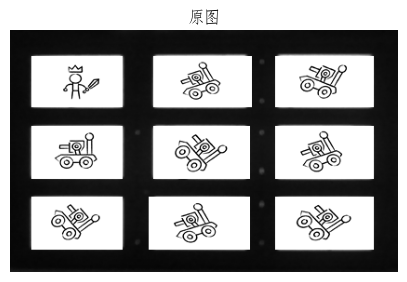

In [8]:
image = cv2.imread('./17.png', 0)

plt.figure(figsize=(5,5))
plt.rcParams['font.sans-serif'] = ['FangSong']
plt.title('原图'), plt.axis('off')
plt.imshow(image, cmap='gray')
plt.show()

16
15
18
17
20
17
18
7
16
MinNum: 7	MinIndex: 7


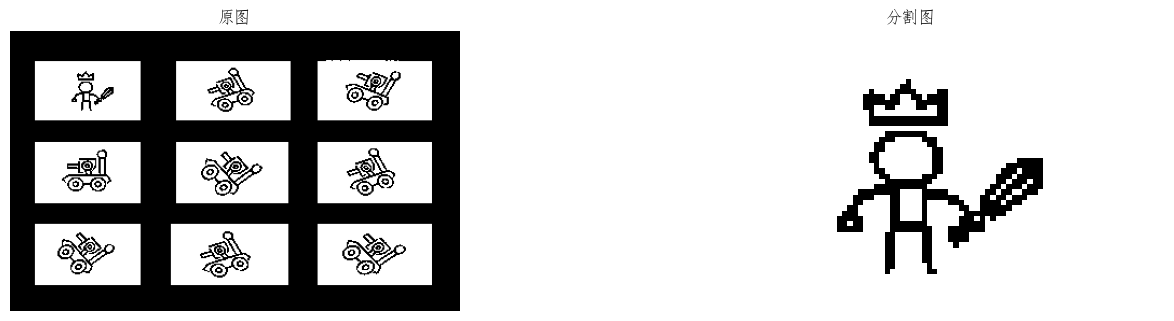

In [9]:
# 进行二值化处理
_, imageBinary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)

# 进行轮廓查找(建立树状)
contours, hierarchy = cv2.findContours(imageBinary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

MinArea = 4000
Nine = []
for index, contour in enumerate(contours):
    rect = cv2.minAreaRect(contour)
    area = cv2.contourArea(contour)
    
    # 进行筛选，可以发现九宫格轮廓的面积较其他轮廓大
    if area > MinArea:
        boxPoint = cv2.boxPoints(rect)
        x = [boxPoint[0][0], boxPoint[1][0], boxPoint[2][0], boxPoint[3][0]]
        y = [boxPoint[0][1], boxPoint[1][1], boxPoint[2][1], boxPoint[3][1]]
        x_min = int(min(x))
        x_max = int(max(x))
        y_min = int(min(y))
        y_max = int(max(y))
        Nine.append([x_min, x_max, y_min, y_max])

# 使用内部轮廓数量这一特征进行筛选
minNum = 100
minIndex = -1
for i in range(len(Nine)):
    roi = imageBinary[Nine[i][2]:Nine[i][3], Nine[i][0]:Nine[i][1]]
    # 计算当前ROI中的轮廓数量
    # 其中数量最少的是人
    
    # 由于存在一些微小空洞，而这会影响到小人的识别
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    errode = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel)
    contoursCut, _ = cv2.findContours(errode, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contoursCut))
    if len(contoursCut) < minNum:
        minNum = len(contoursCut)
        minIndex = i

print("MinNum: {}\tMinIndex: {}".format(minNum, minIndex))
resultImage = imageBinary[Nine[minIndex][2]:Nine[minIndex][3], Nine[minIndex][0]:Nine[minIndex][1]]

plt.figure(figsize=(16,8))
plt.rcParams['font.sans-serif'] = ['FangSong']
plt.subplot(221), plt.title('原图'), plt.axis('off')
plt.imshow(imageBinary, cmap='gray')
plt.subplot(222), plt.title('分割图'), plt.axis('off')
plt.imshow(resultImage, cmap='gray')

In [1]:
root_dir = "./peopleCar"
classes = ['car', 'people']

In [11]:
# 进行分割
#分割九宫格函数
def NineCut(image, flag=0):
    imageNum = 0
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, imageBinary = cv2.threshold(imageGray, 200, 255, cv2.THRESH_BINARY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    imageNineErode = cv2.morphologyEx(imageBinary, cv2.MORPH_ERODE, kernel)
    contoursNine, hierarchyNine = cv2.findContours(imageNineErode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    imageROIs = []
    cornerBox = []
    # 进行九宫格轮廓的筛选，以便于进行分割
    for contour in contoursNine:
        rect = cv2.minAreaRect(contour)
        area = cv2.contourArea(contour)
        
        if area > MinArea:
            # 得到该轮廓的最小面积矩形的四个角点
            cornerPoint = cv2.boxPoints(rect)
            x = [cornerPoint[0][0], cornerPoint[1][0], cornerPoint[2][0], cornerPoint[3][0]]
            y = [cornerPoint[0][1], cornerPoint[1][1], cornerPoint[2][1], cornerPoint[3][1]]
            
            x_min = int(min(x))
            x_max = int(max(x))
            y_min = int(min(y))
            y_max = int(max(y))
            
            # 通过四个角点进行图像分割
            cornerBox.append([x_min, x_max, y_min, y_max])
            imageROI = image[y_min:y_max, x_min:x_max]
            imageROI = cv2.resize(imageROI, (128, 128))
            imageNum = imageNum + 1
            
            # 如果标志位等于1，则将该图片进行存储
            # 在制作数据集的时候进行使用
            if flag == 1:
                cv2.imwrite(root_dir + '/original/' + str(imageNum)+ '.jpg', imageROI)
            imageROIs.append(imageROI)

    return imageROIs, cornerBox

In [13]:
# 添加噪声
def sp_noise(noise_img, proportion):
    height, width = noise_img.shape[0], noise_img.shape[1]#获取高度宽度像素值
    num = int(height * width * proportion) #一个准备加入多少噪声小点
    for i in range(num):
        w = random.randint(0, width - 1)
        h = random.randint(0, height - 1)
        if random.randint(0, 1) == 0:
            noise_img[h, w] = 0
        else:
            noise_img[h, w] = 255
    return noise_img

def gaussian_noise(img, mean, sigma):
    # 将图片灰度标准化
    img = img / 255
    # 产生高斯 noise
    noise = np.random.normal(mean, sigma, img.shape)
    # 将噪声和图片叠加
    gaussian_out = img + noise
    # 将超过 1 的置 1，低于 0 的置 0
    gaussian_out = np.clip(gaussian_out, 0, 1)
    # 将图片灰度范围的恢复为 0-255
    gaussian_out = np.uint8(gaussian_out*255)
    # 将噪声范围搞为 0-255
    # noise = np.uint8(noise*255)
    return gaussian_out# 这里也会返回噪声，注意返回值

def random_noise(image, noise_num):
    # cv2.imshow("src", img)
    rows, cols, chn = image.shape
    # 加噪声
    for i in range(noise_num):
        x = np.random.randint(0, rows)#随机生成指定范围的整数
        y = np.random.randint(0, cols)
        image[x-1:x+1, y-1:y+1, :] = 255
    return image

def rotate_image_randomly(image, angle_range=(-10, 10)):  
    # 获取图像尺寸  
    (h, w) = image.shape[:2]  
      
    # 旋转中心为图像中心  
    center = (w // 2, h // 2)  
      
    # 生成随机角度  
    angle = random.uniform(angle_range[0], angle_range[1])  
      
    # 获取旋转矩阵  
    # 注意OpenCV的旋转角度是逆时针的，所以要旋转顺时针角度，需要传入负值  
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)  
      
    # 计算旋转后的图像尺寸  
    cos = np.abs(M[0, 0])  
    sin = np.abs(M[0, 1])  
      
    # 计算新图像的边界  
    nW = int((h * sin) + (w * cos))  
    nH = int((h * cos) + (w * sin))  
  
    # 调整旋转矩阵以考虑平移  
    M[0, 2] += (nW / 2) - center[0]  
    M[1, 2] += (nH / 2) - center[1]  
  
    # 使用仿射变换进行旋转  
    rotated = cv2.warpAffine(image, M, (nW, nH))  
      
    return rotated

data_path = './peopleCar/train'
path_list = os.listdir(data_path)
# print(path_list)
for i in path_list:
    index_path = data_path+'/'+i
    index_list = os.listdir(index_path)
    
    # 使小人的数据集和小车的数据集数量相当
    if i ==  "people":
        epochs = 200
    else:
        epochs = 25
        
    for j in index_list:
        image_path = index_path + '/' + j
        print(image_path)
        image = cv2.imread(image_path)
        for epoch in range(epochs):
            img = image.copy()
            # 数据增强操作，来制作更多数据集
            rot1 = gaussian_noise(img, 0, 0.15)  # 高斯噪声
            rot2 = random_noise(img, 100)
            rot3 = sp_noise(img, 0.025)
            rot4 = rotate_image_randomly(img)

            img1 = cv2.resize(rot1, (128, 128))
            img2 = cv2.resize(rot2, (128, 128))
            img3 = cv2.resize(rot3, (128, 128))
            img4 = cv2.resize(rot4, (128, 128))
            # 将这些图片进行存储，后续用来制作数据集
            cv2.imwrite(index_path + '/' + j.split('.')[0] + str(epoch) + 'gn.jpg', img1)
            cv2.imwrite(index_path + '/' + j.split('.')[0] + str(epoch) + 'rn.jpg', img2)
            cv2.imwrite(index_path + '/' + j.split('.')[0] + str(epoch) + 'sn.jpg', img3)
            cv2.imwrite(index_path + '/' + j.split('.')[0] + str(epoch) + 'ro.jpg', img4)
#             print(i + ' have saved more img')



./peopleCar/train/car/1.jpg
./peopleCar/train/car/2.jpg
./peopleCar/train/car/3.jpg
./peopleCar/train/car/4.jpg
./peopleCar/train/car/5.jpg
./peopleCar/train/car/6.jpg
./peopleCar/train/car/7.jpg
./peopleCar/train/car/9.jpg
./peopleCar/train/people/8.jpg


In [21]:
image = cv2.imread('./17.png')
# 进行分割制作数据集
imageROIs, cornerBox = NineCut(image, 1)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 识别
# 搭建网络框架
# 搭建CNN
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # 第一次卷积操作：3*128*128->64*126*126
        # 第一次最大池化层：64*126*126->64*63*63
        # 第二次卷积操作：64*63*63->64*61*61
        # 第二次最大池化层: 64*61*61->64*30*30
        # 进行全连接层: (64*30*30)*1
        
        # 卷积操作
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        
        # 最大池化层
        # (H-F+2P)/S+1
        # 当ceil_mode=True时，是向上取整
        self.maxpool = nn.MaxPool2d(2, 2)
        
        # 展平，即全连接层
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*30*30, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        
        x = self.flatten(x)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        # x = self.softmax(x)
        
        return x

model = CNN(2).to(device)


In [23]:
# 设置学习率
learning_rate = 1e-3
# 迭代次数
epochs = 50
# 设置优化器
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# 设置损失函数
loss = nn.CrossEntropyLoss()


In [24]:
# 对数据进行处理
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# 制作数据集
train_dir = "./peopleCar/train/"
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# 得到训练集和测试集的数量
total_samples = len(train_dataset)
test_samples = 200
train_samples = total_samples - test_samples

train_dataset, test_dataset = random_split(train_dataset, [train_samples, test_samples])

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# 训练函数
def train(epoch, model, flag=1, flagtwo=1):
    model.train()
    train_loss = 0
    for data, label in train_loader:
#         print(label)
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        predict = model(data)
#         print(predict, label)
        # label表示的是真实类别的索引，是一个长度为batchsize的张量
        fn_loss = loss(predict, label)
        fn_loss.backward()
        optimizer.step()
        if flagtwo:
            train_loss += fn_loss.item()*data.size(0)
        else:
            train_loss = fn_loss.item()*data.size(0)
            return train_loss
        
    train_loss = train_loss / len(train_loader.dataset)
    if flag:
        print('Epoch: {}\tTraining Loss: {:.6f}'.format(epoch, train_loss))
    return train_loss

In [26]:
# 评估函数
def eval(model, flag=1):
    model.eval()
    actual_labels = []
    predict_labels = []
    with torch.no_grad():
        for data, label in test_loader:
#             print(label)
            data, label = data.to(device), label.to(device)
            output = model(data)
            predict = torch.argmax(output, 1)
            predict_labels.append(predict.cpu().data.numpy())
            actual_labels.append(label.cpu().data.numpy())
    pred_labels, actual_labels = np.concatenate(predict_labels), np.concatenate(actual_labels)
    accuracy = np.sum(pred_labels == actual_labels) / len(pred_labels)
    if flag:
        print("Accuracy: {:.6f}".format(accuracy))
    return accuracy

In [27]:
Loss = []
Accuracy = []
ListEpochs = list(range(1,epochs+1))
for epoch in ListEpochs:
    train_loss = train(epoch, model)
    accuracy = eval(model)
    Loss.append(train_loss)
    Accuracy.append(accuracy)

Epoch: 1	Training Loss: 0.685638
Accuracy: 0.525000
Epoch: 2	Training Loss: 0.673415
Accuracy: 0.475000
Epoch: 3	Training Loss: 0.657645
Accuracy: 0.475000
Epoch: 4	Training Loss: 0.641425
Accuracy: 0.475000
Epoch: 5	Training Loss: 0.623730
Accuracy: 0.755000
Epoch: 6	Training Loss: 0.600069
Accuracy: 0.835000
Epoch: 7	Training Loss: 0.575681
Accuracy: 0.950000
Epoch: 8	Training Loss: 0.545176
Accuracy: 0.965000
Epoch: 9	Training Loss: 0.510300
Accuracy: 0.920000
Epoch: 10	Training Loss: 0.471266
Accuracy: 0.995000
Epoch: 11	Training Loss: 0.425397
Accuracy: 0.935000
Epoch: 12	Training Loss: 0.380714
Accuracy: 0.990000
Epoch: 13	Training Loss: 0.331852
Accuracy: 1.000000
Epoch: 14	Training Loss: 0.283156
Accuracy: 0.995000
Epoch: 15	Training Loss: 0.239065
Accuracy: 1.000000
Epoch: 16	Training Loss: 0.199421
Accuracy: 1.000000
Epoch: 17	Training Loss: 0.165663
Accuracy: 1.000000
Epoch: 18	Training Loss: 0.137784
Accuracy: 1.000000
Epoch: 19	Training Loss: 0.115441
Accuracy: 1.000000
Ep

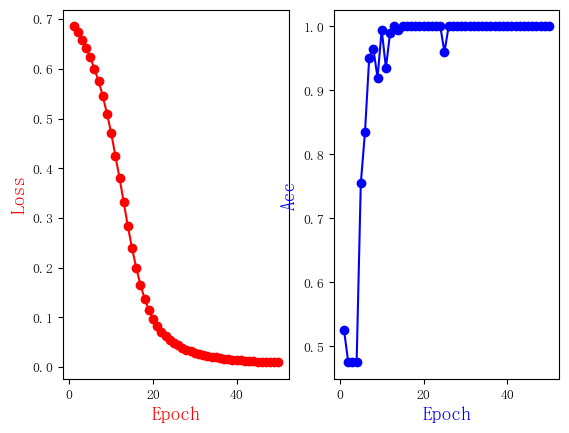

In [30]:
# 画图操作
# 同时进行存储
plt.subplot(121)
plt.plot(ListEpochs, Loss, color='r', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='r')
plt.ylabel('Loss', fontsize=14, color='r')
plt.subplot(122)
plt.plot(ListEpochs, Accuracy, color='b', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='b')
plt.ylabel('Acc', fontsize=14, color='b')
torch.save(model.state_dict(), "mymodel.model")

In [31]:
# 识别函数
def recog(model, imageROI):
        # 对图像进行识别
    recogImage_tensor = torch.tensor(imageROI).float()
    print(recogImage_tensor.shape)
    recogImage_tensor = recogImage_tensor.unsqueeze_(0).permute(0, 3, 1, 2).to(device)
    output = model(recogImage_tensor)
    predict = torch.argmax(output, 1)
    predictList = predict.tolist()
    return predictList

model path exists
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])


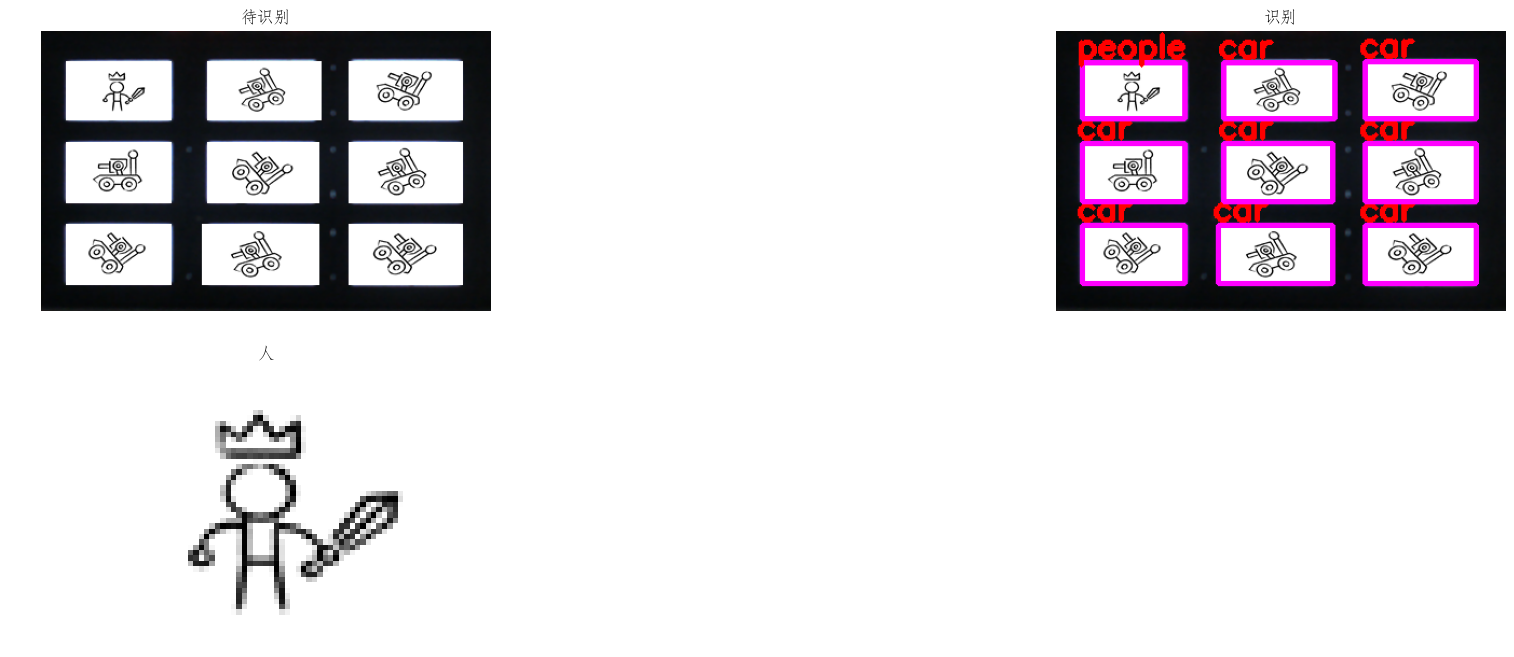

[0]


In [34]:
# 加载模型
# 设置权重文件的路径
state_dict_path = "C:/Users/Whales/图像处理与模式识别第二次实验/mymodel.model"
#判断路径是否存在
if os.path.exists(state_dict_path):
    # 如果权重文件存在，则把他加载进来
    print("model path exists")
    PredictModel = CNN(2).to(device)
    state_dict = torch.load(state_dict_path)
    PredictModel.load_state_dict(state_dict)
else:
    print("model path dosen exist")

image = cv2.imread('./17.png')
imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
polishedImage = imageRGB.copy()

# 得到当前图片各个九宫格中的图像
imageROIs, cornerBox = NineCut(image)
for i in range(len(imageROIs)):
    # 进行预测
    predictList = recog(PredictModel, imageROIs[i])
    
    x_min = cornerBox[i][0]
    x_max = cornerBox[i][1]
    y_min = cornerBox[i][2]
    y_max = cornerBox[i][3]
    
    # 在原图像中画出当前图像的位置并且进行标注
    cv2.rectangle(polishedImage, (x_min, y_min), (x_max, y_max), (255, 0, 255), 3)
    cv2.putText(polishedImage, classes[predictList[0]],
                        (int(x_min-5), int(y_min-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    
    if predictList[0] == 1:
        peopleImage = imageRGB[y_min:y_max, x_min:x_max]
        
plt.figure(figsize=(24,8))
plt.rcParams['font.sans-serif'] = ['FangSong']
plt.subplot(221), plt.title('待识别'), plt.axis('off')
plt.imshow(imageRGB)
plt.subplot(222), plt.title('识别'), plt.axis('off')
plt.imshow(polishedImage)
plt.subplot(223), plt.title('人'), plt.axis('off')
plt.imshow(peopleImage)
plt.show()
print(predictList)